# **Neural Style Transfer**

Neural Style Transfer is a supervised-machine learning technique that takes 2 images, and combines the style from one image with the content of another image.

This Python Notebook is a re-implementation of the research paper [*A Neural Algorithm of Artistic Style*](https://arxiv.org/abs/1508.06576) by Leon A. Gatys, Alexander S. Ecker and Matthias Bethge in 2015.

Essentially, the paper demonstrates how the process of extracting the style of an image and the content of an image using Convolutional Neural Networks are independent of each other. This notebook takes advantage of this property in order to produce a new perception to artistic imagery.

# **Import The VGG19 Model**

In [1]:
#import Tensorflow with Eager Execution
import tensorflow as tf

# Import the VGG19 Pretrained model for feature extraction
from tensorflow.keras.applications.vgg19 import VGG19

In [2]:
model = VGG19(
    # Exclude the top layer since we require only the intermediate layers to act
    # as a feature detector
    include_top = False,
    # Use the VGG19 Model that was trained on the Image Net Dataset, which is
    # efficient in feature detection
    weights = 'imagenet'
)

model.trainable = False

model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

# **Import Modules**
Since we do not want to change the weights of the VGG19 Model, we cannot change the input shape either. Therefore, in order to ensure that we can train our own images using the VGG19 Model, we will have to preprocess the input images to be compatible with the model architecture.
For this purpose we will be importing the following modules below

In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# **Image Preprocessing**


In [4]:
def load_and_process_img(path):
  img = load_img(path)
  img = img_to_array(img)
  img = preprocess_input(img)
  # Expanding the dimensionality of input img since the model expects a
  # 4-dimensional tensor, we expand the dimension by 1
  img = np.expand_dims(img, axis = 0)

  return img

The *preprocess_input()* function from tensorflow uses something called 'mean centering' or 'mean subtraction' where for each channel in the BGR image, the values 103.939, 116.779, 123.68 are subtracted from the channels in that order.
The images themselves are in BGR order instead of RGB because we use the *caffe* framework which uses a different color channel order than the common RGB.



This is a common preprocessing technique used in Deep Learning.

Thus, in order to display these processed images after training or during generation, we must first add back these mean values to the corresponding channels before display, as done in the *reverse_process_img()* function below.

In [5]:
def reverse_process_img(img_array):
  img_array[:,:,0] += 103.939  #Blue Channel
  img_array[:,:,1] += 116.779  #Red Channel
  img_array[:,:,2] += 123.68   #Green Channel

  # Now we reverse the order of channels, i.e, convert the BGR image back to an
  # RGB image
  img_array = img_array[:,:,::-1]
  img_array = np.clip(img_array, 0., 255.).astype('uint8')

  return img_array

In [6]:
def display_processed_img(img_array):
  # Remove the extra dimension that was previously added since the image has
  # already been through the neural net.
  if len(img_array.shape) == 4:
    img_array = np.squeeze(img_array, axis = 0)

  img_array = reverse_process_img(img_array)

  # Display the processed image
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img_array)
  #plt.show()
  return

**The following two images are the content image and style image we will be trying to combine respectively**

Note that while these images are displayed as such, when trying to run this notebook on your own, you must upload the images yourself before running the next two cells of code. The images that this notebook initally worked on can be found in the Github repository from which this notebook was opened.

You are more than welcome to upload your own images and see how the model performs on those images.

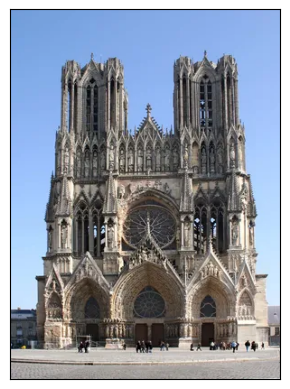

In [7]:
display_processed_img(load_and_process_img('/content/content.jpg'))

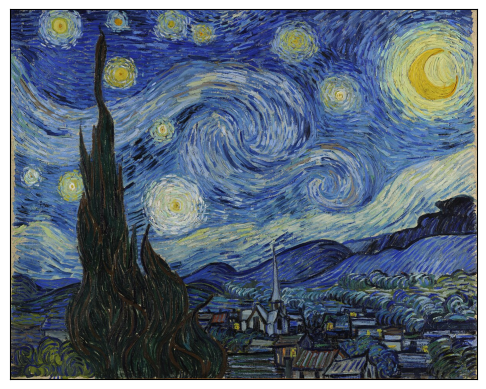

In [8]:
display_processed_img(load_and_process_img('/content/style.jpg'))

# **Content and Style Models**

In order to compute the content and style costs, a combination of which will later be optimized, we need to use the intermediate layers from the VGG19 Model.

We're using the 1st convolutional layer from the 5th block in the architecture as the content_layer. This layer is pretty deep and therefore we expect a large portion of the features of an image to be extracted by this point.

For the style layers however, we use 3 different layers from the model architecture. This is so that we learn not only the high-level stylistic features or the low-level ones, but a combination of all, thus giving an accurate metric for style cost.

Most reimplementations of the Neural Style Transfer technique use 5 layers for the style layers, generally one convolution layer from each block, but we will be only using 3 to speed up computational efficieny.

In [9]:
content_layer = 'block5_conv1'
style_layers = ['block1_conv1', 'block3_conv1', 'block5_conv1']

In order to use the activations from these selected layers, we would have to create a seperate model for each layer used. In these newly created models, the the activations of the selected layer will be the output of the model, thus allowing us to use the activations as required.

The following code implements this idea.

In [10]:
content_model = Model(inputs = model.input, outputs = model.get_layer(content_layer).output)
style_models = [
    Model(inputs = model.input, outputs = model.get_layer(style_layers[2]).output),
    Model(inputs = model.input, outputs = model.get_layer(style_layers[1]).output),
    Model(inputs = model.input, outputs = model.get_layer(style_layers[0]).output)
]


In order to compute content costs, we need to store the output of the content model on both the original content image, and the proposed stylized image.

Furthermore, we would need to calculate the Mean Squared Error between these 2 outputs, in order to evaluate how well the VGG19 model upto the specified layer captures the features from an image.

In [11]:
def compute_content_cost(content_image, generated_image):
  # Compute Content outputs
  content_img_output = content_model(content_image)
  generated_img_output = content_model(generated_image)

  # Compute Mean Squared Error
  content_cost = tf.reduce_mean(tf.square(content_img_output, generated_img_output))

  return content_cost

# **Gram Matrix**
The Gram Matrix is calculated by multiplying a matrix with its transpose to obtain the degree of correlation between any two rows (features) of the original matrix. This is useful in representing the style of an image.

While a Deep Convolutional Network can efficiently extract the specific features from a given image, it extracts these features/convolutions in a way that are independent of each other. Therefore, we do not have an idea of how these features are related to each other.

Groups of features that occur together in unison help us percieve the style of an image. This style can be extracted by first converting each convolution into a feature vector and combining each feature vector to produce a matrix. The Gram Matrix of the resulting matrix produces the style of a given image.

In [12]:
def compute_gram_matrix(array):
  num_channels = int(array.shape[-1])
  # Reshape array to produce a matrix
  matrix = tf.reshape(array, [-1, num_channels])
  num_elements = tf.shape(matrix)[0]
  # Compute the dot product of the matrix with its transpose
  gram = tf.matmul(matrix, matrix, transpose_a = True)

  return gram / tf.cast(num_elements, tf.float32)

# **Style Cost**
The style cost for this our model is a weighted sum of the three style models we created using block5_conv1, block3_conv1 and block1_conv1 layers of the VGG19 Model.

This is done below.

In [13]:
# Initialize the weight for the weighted sum
style_weight = 1. / len(style_models)

def compute_style_cost(style_image, generated_image):
  total_cost = 0
  # Compute the style cost for each style model
  for model in style_models:
    style_activations = model(style_image)
    generated_activations = model(generated_image)
    gram_style = compute_gram_matrix(style_activations)
    gram_generated = compute_gram_matrix(generated_activations)
    total_cost += tf.reduce_mean(tf.square(gram_style - gram_generated)) * style_weight

  return total_cost

# **Training the Model**


We are training the model for around 30 epochs.With a T4 GPU, this takes about 2-3 minutes. If you are running this on your local machine with a regular CPU and the same number of epochs, this will take around 10 minutes to run the loop.

Here, we train for 30 epochs to study the progression of the content image into a more stylized version of itself through each epoch.

In [14]:
intermediate_images = []
def training_loop(content_img_path, style_img_path, epochs, alpha, beta):
  content_img = load_and_process_img(content_img_path)
  style_img = load_and_process_img(style_img_path)
  generated_img = tf.Variable(content_img, dtype=tf.float32)

  optimizer = tf.keras.optimizers.Adam(learning_rate = 7.)

  best_cost = float('inf')
  best_image = None

  for i in range(epochs):
    with tf.GradientTape() as tape:
      content_cost = compute_content_cost(content_img, generated_img)
      style_cost = compute_style_cost(style_img, generated_img)
      total_cost = (alpha * content_cost) + (beta * style_cost)

    gradients = tape.gradient(total_cost, generated_img)
    optimizer.apply_gradients([(gradients, generated_img)])

    if total_cost < best_cost:
      best_cost = total_cost
      best_image = generated_img.numpy()

    print("epoch {}. --> cost: {}".format(i, total_cost))
    intermediate_images.append(generated_img.numpy())

  return best_image

In [15]:
best_image = training_loop('/content/content.jpg', '/content/style.jpg', 30, 10., 20.)

epoch 0. --> cost: 4035069184.0
epoch 1. --> cost: 1772388736.0
epoch 2. --> cost: 1120834432.0
epoch 3. --> cost: 972984960.0
epoch 4. --> cost: 659973760.0
epoch 5. --> cost: 511002784.0
epoch 6. --> cost: 433658784.0
epoch 7. --> cost: 385220832.0
epoch 8. --> cost: 346096992.0
epoch 9. --> cost: 294645632.0
epoch 10. --> cost: 252200864.0
epoch 11. --> cost: 222487728.0
epoch 12. --> cost: 196750656.0
epoch 13. --> cost: 179762160.0
epoch 14. --> cost: 163723872.0
epoch 15. --> cost: 144162352.0
epoch 16. --> cost: 132001096.0
epoch 17. --> cost: 123759040.0
epoch 18. --> cost: 113076232.0
epoch 19. --> cost: 103799872.0
epoch 20. --> cost: 96522632.0
epoch 21. --> cost: 89300560.0
epoch 22. --> cost: 82598304.0
epoch 23. --> cost: 75928336.0
epoch 24. --> cost: 70927200.0
epoch 25. --> cost: 67531160.0
epoch 26. --> cost: 62934256.0
epoch 27. --> cost: 58831220.0
epoch 28. --> cost: 55931100.0
epoch 29. --> cost: 52675044.0


# **Plot Results**

Now that we have the best image from training i.e, the image that has the lowest cost, we can see the style from the style image combined with the content image to produce a new image that produces a new sense of perception of the two images.

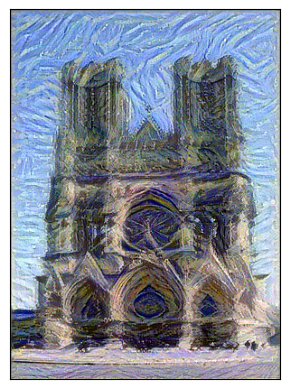

In [16]:
display_processed_img(best_image)

Now, we can see how our training loop has gradually augmented the provided content image and transformed it into the style image.

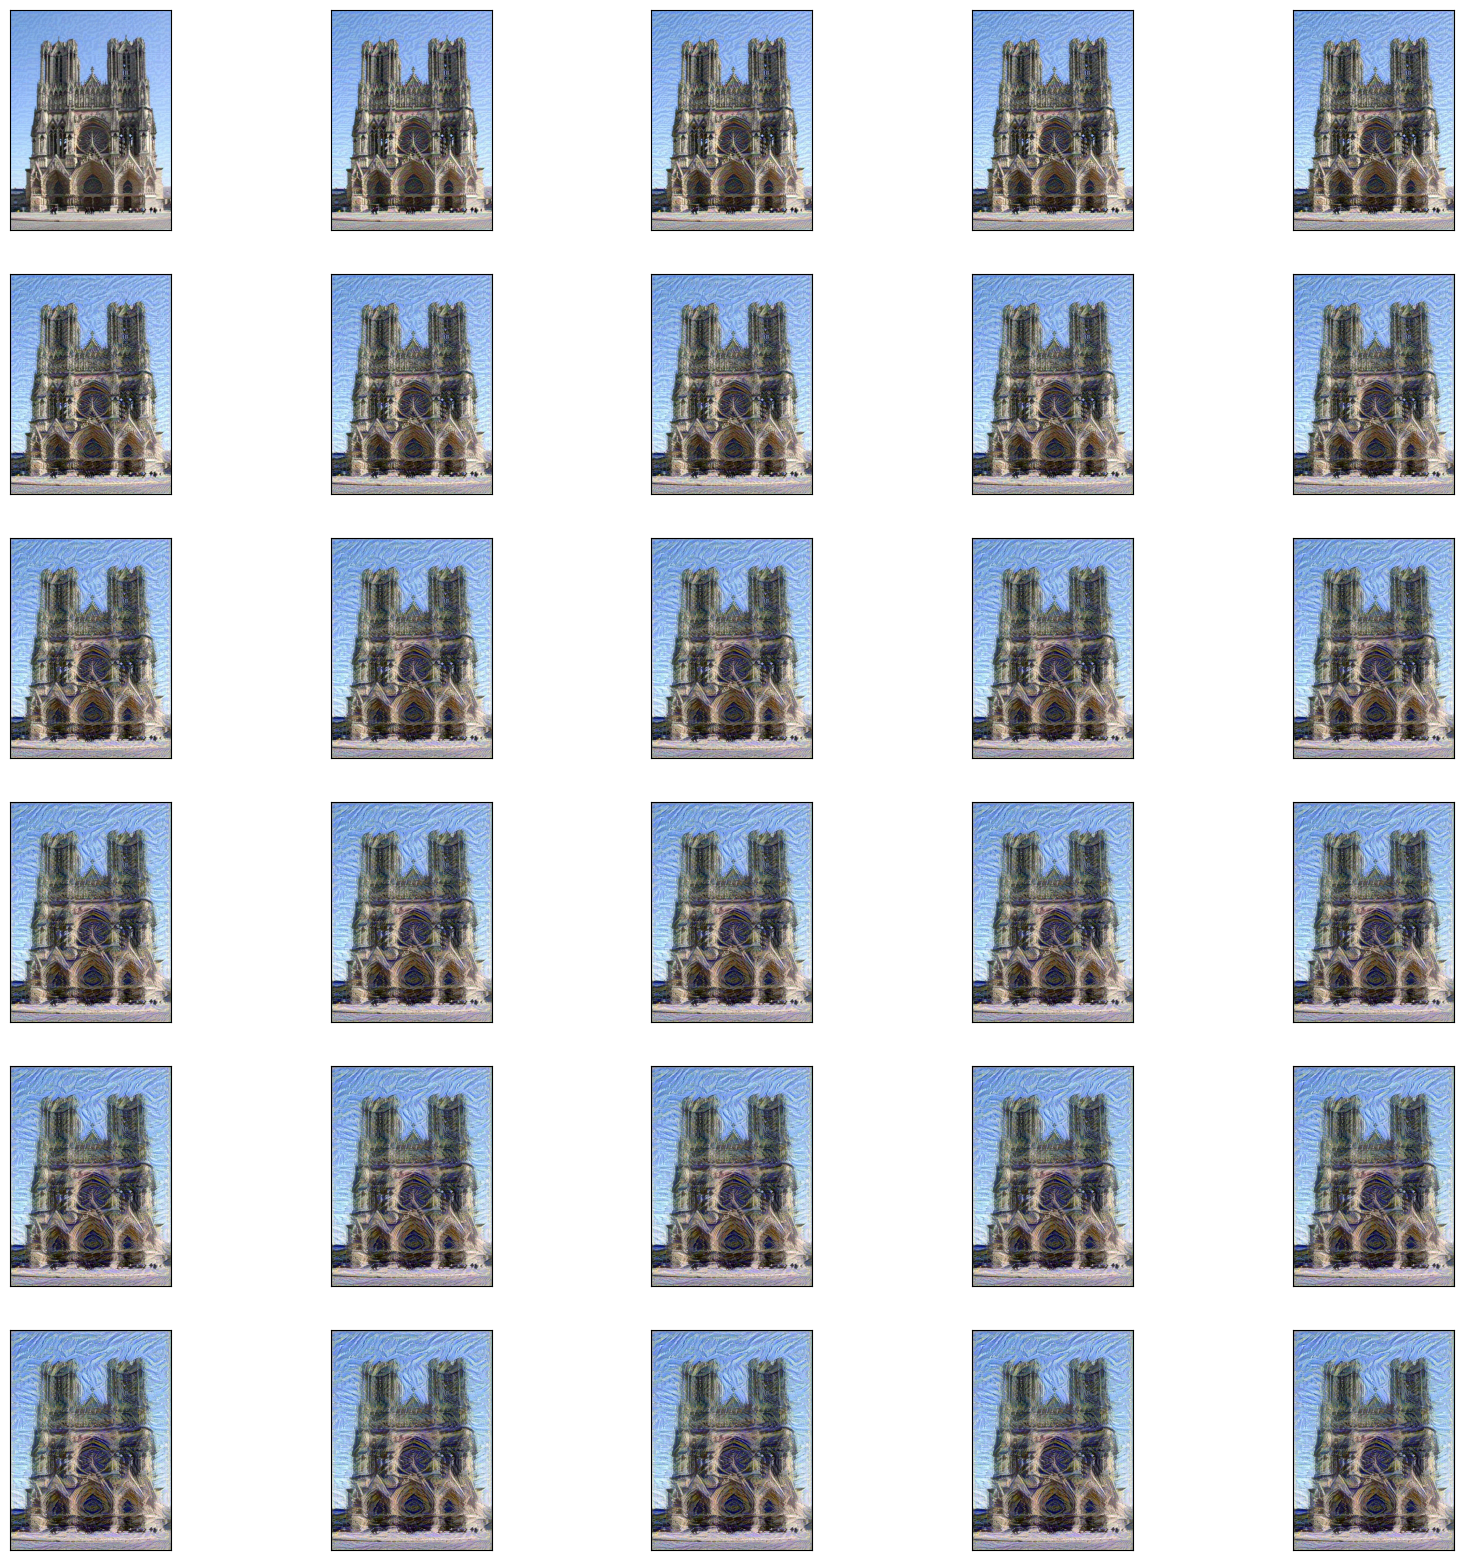

In [17]:
plt.figure(figsize = (20,20))
for i in range(30):
    plt.subplot(6, 5, i+1)
    display_processed_img(intermediate_images[i])
plt.show()


As you can see above, though the progress is gradual, the content images slowly becomes more stylized as the epochs go on. Depending on the number of epochs you train the model for, the stylistic features can be more or less emphasized.

One way to explain this gradual change is through the gradual decrease in the cost function. You can notice this by going through the cost incurred at the end of each epoch of the training loop.

And voila! We combined the famous Van Gogh Painting with a Cathedral to produce an image of a Cathedral in the style of Van Gogh.

# **Conclusion**

This brings us to the end of this notebook.
Feel free to download the notebook and play around with different parameters such as the optimizers, number of epochs, loss metrics, learning rates used etc.

I hope you enjoyed learning about Neural Style Transfer as much as I did!